# Import Libraries

This code includes various libraries and modules for deep learning and computer vision, such as PyTorch, torchvision, and matplotlib. It also imports argparse and os, which are used for handling command-line arguments and interacting with the operating system, respectively. Finally, it imports HTML from IPython.display to display the generated images as an animation in a Jupyter notebook.

In [1]:
import os
import random
import argparse
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set Hyperparameters

This code sets up some of the key hyperparameters for the DCGAN model:

    dataroot: the directory where the dataset is stored.
    workers: the number of subprocesses to use for data loading.
    batch_size: the number of samples per batch to load.
    image_size: the spatial size of the images used for training.
    nc: the number of color channels in the input images.
    nz: the size of the noise vector used as input to the generator.
    ngf: the size of the feature maps in the generator.
    ndf: the size of the feature maps in the discriminator.
    num_epochs: the number of training epochs.
    lr: the learning rate for the optimizer.
    beta1: the beta1 hyperparameter for the Adam optimizer.
    ngpu: the number of GPUs available to use (in this case, 1).

In [2]:
# root directory for dataset
dataroot = "/kaggle/input/age-recognition-dataset/Dataset"

# number of workers for dataloader
workers = 2

# batch size during training
batch_size = 128

# All images will be resized to this spatial size of training images
#  using a transformer.
image_size = 64

# number of channels in the training images. For color images this is 3
nc = 3

# size of z latent vector (i.e. size of generator input)
nz = 100

# size of feature maps in generator
ngf = 64

# size of feature maps in discriminator
ndf = 64

# number of training epochs
num_epochs = 20

# learning rate for optimizers
lr = 0.0002

# beta1 hyperparam for Adam optimizers
beta1 = 0.5

# number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Create Dataset

This code is preparing the dataset for the DCGAN model. It is creating an ImageFolder dataset by specifying the root directory where the images are stored and applying some transformations to the images, such as resizing and normalization. Then it creates a dataloader that loads the data in batches and shuffles it. The code also checks if there is a GPU available and decides whether to use it or the CPU. Finally, it plots some training images by taking a batch of real images from the dataloader and visualizing them using Matplotlib.

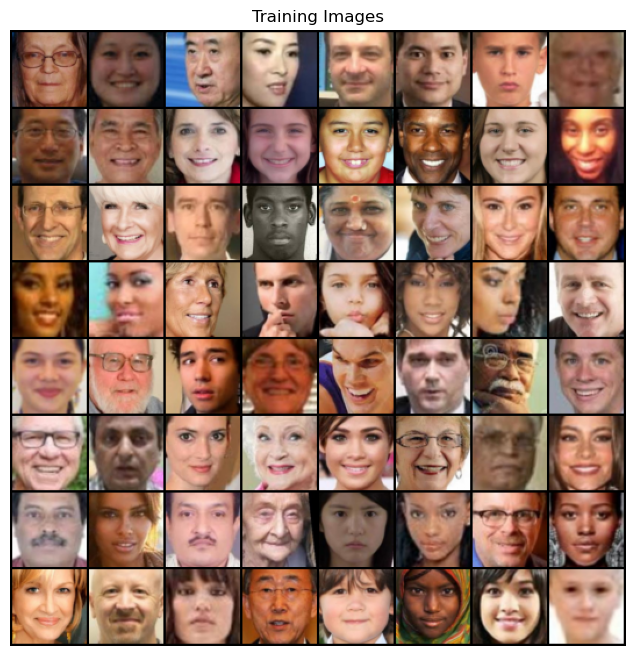

In [3]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset.
dataset = dset.ImageFolder(root = dataroot,
                           transform = transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader.
dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size,
                                         shuffle = True, num_workers = workers)

# Decide which device we want to run on.
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images.
real_batch = next(iter(dataloader))
plt.figure(figsize = (8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding = 2, normalize = True).cpu(),(1, 2, 0)))

# Initialize Custom Weights

This is a Python function called weights_init that initializes the weights of a neural network model. Specifically, it sets the weights of the convolutional layers to be sampled from a normal distribution with a mean of 0 and a standard deviation of 0.02, and the weights of the batch normalization layers to be sampled from a normal distribution with a mean of 1 and a standard deviation of 0.02, while setting the biases of the batch normalization layers to 0.

The function takes in a single argument, m, which represents a module of the neural network. It checks the type of the module (Conv or BatchNorm) and initializes its weights accordingly.

In [4]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Create the Generator

This is the code for the generator neural network. The Generator class is defined as a subclass of nn.Module, which is the base class for all neural network modules in PyTorch.

The constructor method of the Generator class takes the ngpu argument, which represents the number of GPUs available.

The main part of the generator is defined in the self.main Sequential object, which contains a series of layers to transform the input noise vector into an output image.

The generator takes a noise vector of size nz as input and transforms it into an image of size nc. The main layers of the generator include ConvTranspose2d layers, BatchNorm2d layers, and ReLU activation layers.

The forward method of the Generator class takes an input tensor and applies the main layers to it. Finally, it returns the output of the main layers, which is the generated image.

In [5]:
# generator code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # Input is Z, going into a convolution.
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias = False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # State size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias = False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # State size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias = False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # State size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias = False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # State size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias = False),
            nn.Tanh()
            # State size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

This code defines the generator model for a GAN (Generative Adversarial Network).

The Generator class is defined as a subclass of nn.Module, which is the base class for all neural network modules in PyTorch.

The constructor method __init__ takes ngpu (number of GPUs) as an argument and sets it as an attribute of the instance. The main attribute is defined as a sequence of convolutional transpose layers with batch normalization and ReLU activation functions. The sequence starts with a convolutional transpose layer that takes the input nz (size of z latent vector) and outputs a tensor of size ngf*8 x 4 x 4. Each subsequent convolutional transpose layer doubles the number of channels until it reaches ngf x 64 x 64. The final layer uses the hyperbolic tangent activation function to output a tensor of size nc x 64 x 64 (where nc is the number of channels in the training images).

The forward method takes an input tensor input and passes it through the layers defined in self.main, returning the output tensor.

The code then creates an instance of the Generator class called netG and moves it to the device specified by device (GPU if available, CPU otherwise). The weights_init function is applied to randomly initialize all weights in netG. Finally, the netG model is printed.

In [6]:
# Create the generator.
netG = Generator(ngpu).to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model.
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


# Create the Discriminator

The code defines the discriminator neural network class, which inherits from the nn.Module class in PyTorch. The discriminator takes as input a 3-channel (RGB) image of size 64x64 pixels and outputs a scalar value between 0 and 1 indicating whether the input image is real or fake. The architecture of the discriminator consists of four convolutional layers followed by a fully connected layer with a sigmoid activation function.

The constructor method __init__() initializes the class by defining the architecture of the discriminator network. The method takes ngpu as an input argument, which specifies the number of GPUs used for training (0 for CPU mode). The discriminator network architecture consists of four convolutional layers followed by a fully connected layer with a sigmoid activation function.

The forward method forward() defines the forward pass of the discriminator network. It takes an input tensor input and returns the output of the network after applying the sequential layers defined in the constructor method.

In [7]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # Input is (nc) x 64 x 64.
            nn.Conv2d(nc, ndf, 4, 2, 1, bias = False),
            nn.LeakyReLU(0.2, inplace = True),
            # State size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias = False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace = True),
            # State size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias = False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace = True),
            # State size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias = False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace = True),
            # State size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias = False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

This code defines the Discriminator model, which is a neural network that takes an image as input and predicts whether it is real or fake. It consists of several convolutional layers, each followed by a batch normalization and a leaky ReLU activation function. The output of the last convolutional layer is flattened and fed into a single sigmoid output unit that predicts the probability that the input image is real.

The function weights_init is also defined here, which is used to initialize the weights of the neural networks to have a mean of 0 and standard deviation of 0.2.

The code instantiates an instance of the Discriminator class called netD with the specified number of GPUs and applies the weights_init function to initialize the model's weights. The model is then printed to show its architecture.

In [8]:
# Create the Discriminator.
netD = Discriminator(ngpu).to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model.
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


# Training

The code initializes the binary cross-entropy loss function (BCELoss) and creates a fixed batch of random noise (fixed_noise) that will be used to visualize the progression of the generator during training. It also establishes the convention for real and fake labels during training, where a real image is labeled with 1 and a fake image generated by the generator is labeled with 0. Finally, it sets up the Adam optimizer for both the generator (optimizerG) and the discriminator (optimizerD) using the specified learning rate (lr) and beta1 hyperparameter.

In [9]:
# Initialize BCELoss function.
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator.
fixed_noise = torch.randn(64, nz, 1, 1, device = device)

# Establish convention for real and fake labels during training.
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D.
optimizerD = optim.Adam(netD.parameters(), lr = lr, betas = (beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr = lr, betas = (beta1, 0.999))

This is the training loop of a GAN (Generative Adversarial Network). It consists of two main parts: training the discriminator and training the generator.

In the discriminator training part, the discriminator is trained on a batch of real images and a batch of fake images generated by the generator. The discriminator's task is to classify the images as real or fake, while the generator's task is to generate images that fool the discriminator into thinking they are real. The loss function used is binary cross-entropy loss, which compares the discriminator's output to the actual label (real or fake).

In the generator training part, the generator is trained to generate images that the discriminator thinks are real. The loss function used is again binary cross-entropy loss, but this time the generator tries to maximize it instead of minimizing it.

The loop saves the losses for plotting later and saves the generated images from the fixed noise vector every 500 iterations. At the end of each epoch, the loop prints the current loss values and the discriminator's accuracy in classifying the real and fake images.

In [10]:
# training Loop

# lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# for each epoch
for epoch in range(num_epochs):
    # for each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z))).
        ###########################
        ## Train with all-real batch.
        netD.zero_grad()
        # format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device = device)
        # Forward pass real batch through D.
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch.
        errD_real = criterion(output, label.float())
        # Calculate gradients for D in backward pass.
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch.
        # Generate batch of latent vectors.
        noise = torch.randn(b_size, nz, 1, 1, device = device)
        # Generate fake image batch with G.
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D.
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch.
        errD_fake = criterion(output, label.float())
        # Calculate the gradients for this batch.
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches.
        errD = errD_real + errD_fake
        # Update D.
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z))).
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # Fake labels are real for generator cost.
        # Since we just updated D, perform another forward pass of all-fake batch through D.
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output.
        errG = criterion(output, label.float())
        # Calculate gradients for G.
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G.
        optimizerG.step()

        # Output training stats.
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later.
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise.
        if (iters % 500 == 0) or ((epoch == num_epochs - 1) and (i == len(dataloader) - 1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding = 2, normalize = True))

        iters += 1

Starting Training Loop...
[0/20][0/72]	Loss_D: 1.9098	Loss_G: 2.4775	D(x): 0.2678	D(G(z)): 0.2879 / 0.1133
[0/20][50/72]	Loss_D: 0.4619	Loss_G: 17.8265	D(x): 0.7966	D(G(z)): 0.0000 / 0.0000
[1/20][0/72]	Loss_D: 2.7848	Loss_G: 27.0253	D(x): 0.9762	D(G(z)): 0.8088 / 0.0000
[1/20][50/72]	Loss_D: 0.4326	Loss_G: 7.9668	D(x): 0.9593	D(G(z)): 0.2727 / 0.0023
[2/20][0/72]	Loss_D: 0.4617	Loss_G: 7.0200	D(x): 0.9156	D(G(z)): 0.2374 / 0.0073
[2/20][50/72]	Loss_D: 0.3388	Loss_G: 4.9378	D(x): 0.8113	D(G(z)): 0.0412 / 0.0143
[3/20][0/72]	Loss_D: 0.1742	Loss_G: 6.4792	D(x): 0.8781	D(G(z)): 0.0219 / 0.0024
[3/20][50/72]	Loss_D: 0.5430	Loss_G: 3.3817	D(x): 0.7249	D(G(z)): 0.0496 / 0.0472
[4/20][0/72]	Loss_D: 1.3981	Loss_G: 9.8085	D(x): 0.9929	D(G(z)): 0.6807 / 0.0002
[4/20][50/72]	Loss_D: 0.4970	Loss_G: 5.7138	D(x): 0.8941	D(G(z)): 0.2493 / 0.0071
[5/20][0/72]	Loss_D: 0.3275	Loss_G: 5.7254	D(x): 0.9279	D(G(z)): 0.1798 / 0.0072
[5/20][50/72]	Loss_D: 0.4962	Loss_G: 8.2623	D(x): 0.9110	D(G(z)): 0.2800 / 0

This code plots the generator and discriminator loss during the training of the GAN. The x-axis represents the number of iterations and the y-axis represents the loss value. The generator loss is plotted in blue and the discriminator loss is plotted in orange. The plot helps to visualize the progress of the training and whether the generator and discriminator are improving over time.

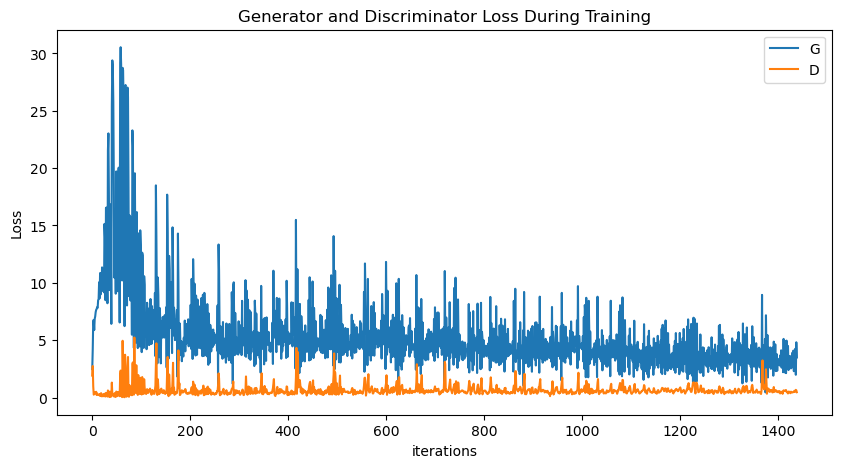

In [11]:
plt.figure(figsize = (10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label = "G")
plt.plot(D_losses,label = "D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# The Original Images and the Created Fake Images

This code is likely part of a GAN (Generative Adversarial Network) implementation, used to generate fake images that resemble real images.

The code is generating and plotting a batch of real images from a dataloader. Then it is plotting the fake images generated by the GAN model in the last epoch. The fake images are generated using a noise vector as input to the generator part of the GAN, and then the discriminator part of the GAN is used to evaluate how realistic the generated images are. The generator is trained to improve its ability to generate realistic images by optimizing its parameters through backpropagation using the loss calculated by the discriminator.

The purpose of comparing the real and fake images is to evaluate how well the GAN model is able to generate realistic images that resemble the real images.

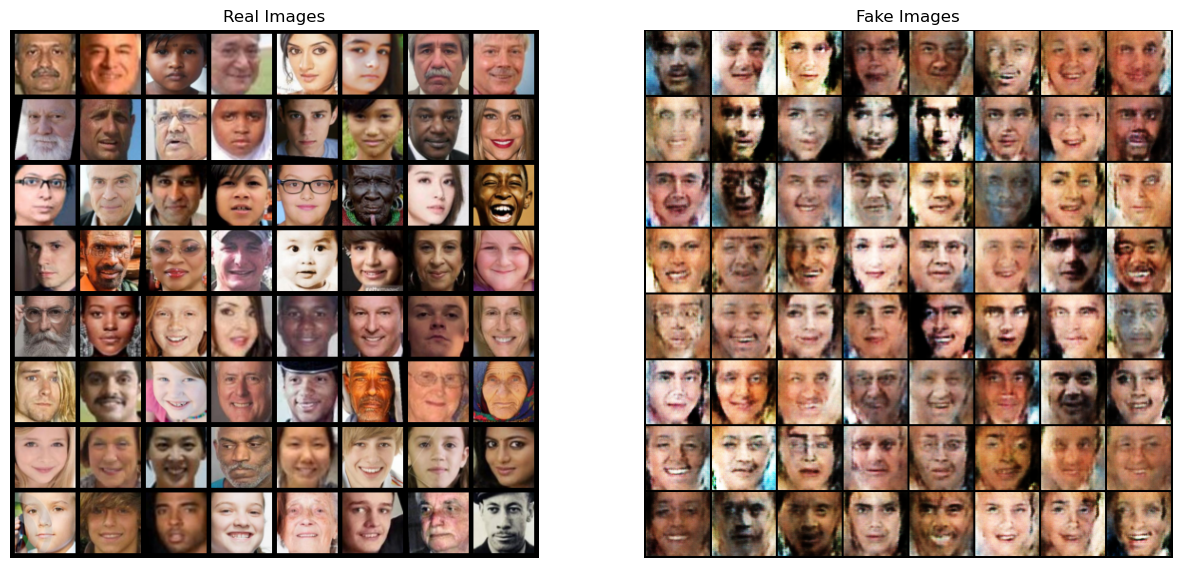

In [12]:
# Grab a batch of real images from the dataloader.
real_batch = next(iter(dataloader))

# Plot the real images.
plt.figure(figsize = (15, 15))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding = 5, normalize = True).cpu(), (1, 2, 0)))

# Plot the fake images from the last epoch.
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))
plt.show()

This code block is generating an animation of the generated images over the course of training using the Matplotlib library.

The first line, #%%capture, is a command used in Jupyter notebooks to capture the output of the cell and prevent it from being displayed.

The code then creates a figure and sets the axis to be off. It then creates a list of images from the img_list variable, which contains the generated images. The plt.imshow function is used to display the images, and the animation.ArtistAnimation function is used to create an animation from these images. Finally, the HTML function is used to display the animation as a HTML5 video.

Note that this code block assumes that img_list contains a list of 3D arrays representing the generated images.

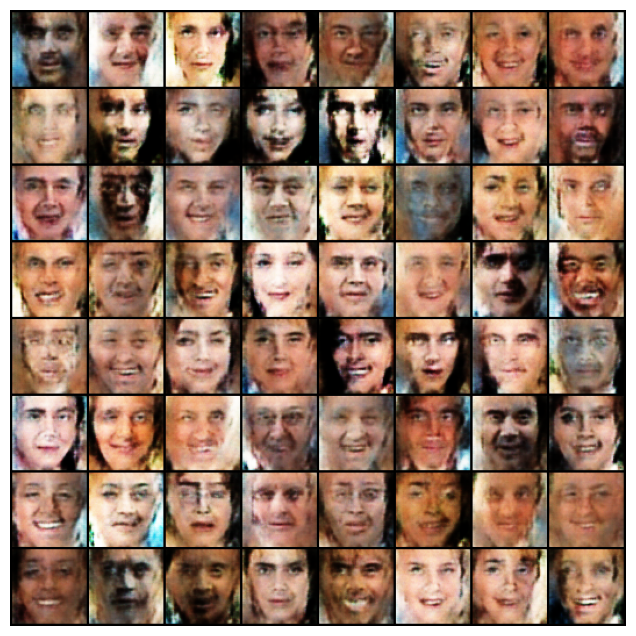

In [13]:
# %%capture
fig = plt.figure(figsize = (8, 8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i, (1, 2, 0)), animated = True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval = 1000, repeat_delay = 1000, blit = True)

HTML(ani.to_jshtml())